adding import lib

In [65]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
import matplotlib.pyplot as plt
#from sklearn.svm import LinearSVC

define a extract haralick features function

In [66]:
def extract_haralick_features(image):
        features = mt.features.haralick(image)

        haralick_features_mean = features.mean(axis=0)
        return haralick_features_mean

define a extract Local binary patterns (LBP) function

In [67]:
def extract_LBP(image):
    feat = mt.features.lbp(image=image, points=(2*8), radius=2, ignore_zeros="True")
    feat = np.reshape(cv2.calcHist([np.float32(feat)], [0], None, [256], [0, 256]),(256))
    return feat

Divide the picture as grids (5x4) and calculate features

In [68]:
def features_of_grid(image):
    height = image.shape[0]
    width = image.shape[1]    

    x_step = int(width / 5)
    y_step = int(height / 4)

    x = 0
    y= 0
    
    all_features = []

    for i in range(5):
        if i < 4: 
            w = x_step 
        else:
            w = width - x
        for j in range(4):
            if j < 3: 
                h = y_step 
            else:
                h = height - y
            
            crop_img = image[y:y+h, x:x+w] 
            
            y += h
            if i == 0 and j == 0:
                all_features = extract_haralick_features(crop_img)
            elif i == 0 and j == 1:
                hfc = extract_haralick_features(crop_img)
                all_features = np.stack((all_features, hfc), axis=-1)
            else:
                hfc = []
                hfc.append(extract_haralick_features(crop_img))
                hfc = np.asarray(hfc)
                all_features = np.concatenate((all_features, hfc.T), axis=1)
        x += w
        y= 0
            
    return all_features
    

get haralick features of a probe (20*2*13 - Parameters)

In [69]:
def get_haralick_feature_of_a_probe(image1_path, image2_path):
    image = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    f = np.column_stack((features_of_grid(gray), features_of_grid(gray2)))
    return f


In [70]:
#stufe
fs = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/ProbeE2/2D/ProbeE2_1_makro_cut.png", 
                                        "../Klebeverbindungen_Daten/ProbeE2/2D/ProbeE2_2_makro_cut.png")
#schräge30
fs30 = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/ProbeS1/2D/ProbeS1_1_makro_cut.png", 
                                        "../Klebeverbindungen_Daten/ProbeS1/2D/ProbeS1_2_makro_cut.png")
#schräge60
fs60  = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/ProbeS2/2D/ProbeS2_1_makro_cut.png", 
                                        "../Klebeverbindungen_Daten/ProbeS2/2D/ProbeS2_2_makro_cut.png")
#runde
fr = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/ProbeR1/2D/ProbeR1_1_makro_cut.png", 
                                       "../Klebeverbindungen_Daten/ProbeR1/2D/ProbeR1_2_makro_cut.png" )

visualize calculated features

<Figure size 432x288 with 0 Axes>

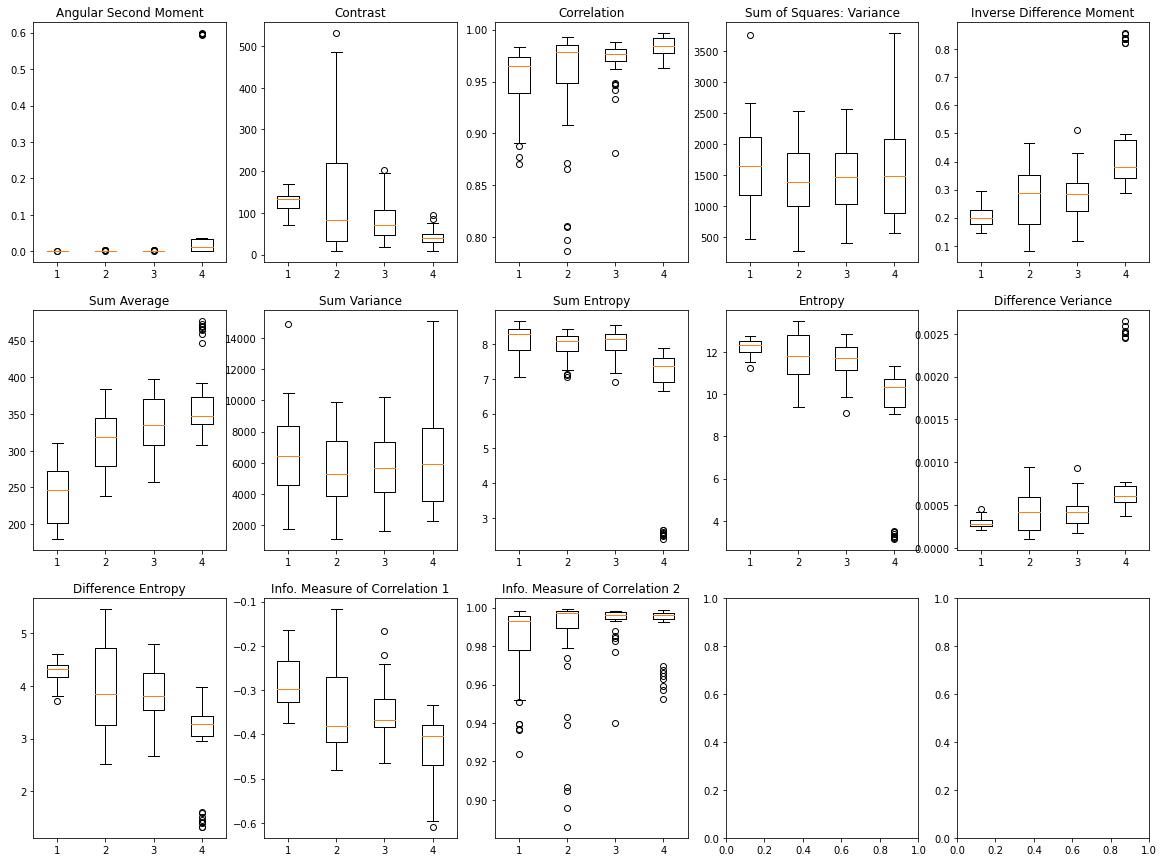

In [71]:
fig = plt.figure()

fig, axs = plt.subplots(3, 5, figsize=(20,15))
langs = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
        "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
y_axis = np.arange(40)
for i in range(13):
        x = int(i/5)
        y = int(i % 5)
        axs[x,y].boxplot([fs[i], fs30[i], fs60[i], fr[i]])
        
        axs[x,y].set_title(langs[i])
